# SuStaIn tutorial using simulated data

Written by Alex Young in April 2020, last updated in October 2022. Please email alexandra.young@kcl.ac.uk with any questions.

This tutorial demonstrates how to run Subtype and Stage Inference (SuStaIn) using simulated data. SuStaIn is an unsupervised learning algorithm that identifies subgroups of individuals with distinct biomarker progression patterns. See [Young et al. Nature Communications 2018](https://doi.org/10.1038/s41467-018-05892-0) for more details.

SuStaIn is a generalisable algorithm in which you can choose how to model the progression of biomarkers within a subtype. In this tutorial I use the linear z-score model I used in [Young et al. 2018](https://doi.org/10.1038/s41467-018-05892-0), but it is possible to use other models of biomarker evolution, such as the event-based model.

For a demonstration of the 'event-based'/mixture modelling version of SuStaIn (i.e. MixtureSustain), see simrun.py, available in the /sim subdirectory of the pySuStaIn package.

## Installing SuStaIn and setting it up to run in a notebook

To get SuStaIn up and running first you need to install the package. I'm using Anaconda and had some conflicts with existing packagaes so I had to create a new environment. For me the whole set up process looked like this...

Step 1: Open up a terminal window and create a new environment "sustain_env" in anaconda that uses python 3.7 and activate the environment ready to install pySuStaIn.
```console
conda create --name sustain_tutorial_env python=3.7
conda activate sustain_tutorial_env
```

Step 2: Use the terminal to install necessary packages for running the notebook and pySuStaIn within the environment.
```console
conda install -y ipython jupyter matplotlib statsmodels numpy pandas scipy seaborn pip
pip install git+https://github.com/ucl-pond/pySuStaIn
```

Step 3: Use the terminal to run the notebook from inside the environment.
```console
jupyter notebook
```

Once you've got your environment running the general workflow will be to open a terminal window and navigate to the directory with the notebook in, activate the envirnoment, open a jupyter notebook inside and use the notebook to run your analyses, then use the terminal deactivate the environment once you've finished running analyses.
```console
conda activate sustain_tutorial_env
jupyter notebook
conda deactivate
```

## Importing packages

In [1]:
# import the python packages needed to generate simulated data for the tutorial
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import pySuStaIn

# this needs to point to wherever the sim folder inside pySuStaIn is on your computer
sys.path.insert(0,'/Users/seymour/Downloads/pySuStaIn-1-master_2/sim')
# if you're running the notebook from within the existing structure you can use
# sys.path.insert(0,'../sim/')
from simfuncs import generate_random_Zscore_sustain_model, generate_data_Zscore_sustain

## The linear z-score model

The linear z-score model I use in this tutorial describes a subtype progression pattern as the linear evolution of biomarkers between different z-scores. Figure 1 below shows an example of what this model looks like for a single subtype. The model is indexed by a set of discrete stages. Each stage corresponds to a biomarker reaching a new z-score from the set of z-scores for each biomarker, Z_vals. Each biomarker starts with a minimum value of 0 at stage 0 and reaches a maximum of Z_max at the final stage of the progression. The number of stages is determined by the number of biomarkers and z-scores in Z_vals. The SuStaIn algorithm identifies subgroups of individuals and their progression patterns - for the linear z-score model the progression pattern would be the ordering of the different biomarker z-scores in Z_vals - gt_sequence below.

You can play around generating different sequences and altering the settings of the linear z-score model using the code below.

Simulated sequence: [ 2  1  7  9  4  6  3  0 13 19 11 14 20 10  8  5 16 17 12 15 18]
At the beginning of the progression (stage 0) the biomarkers have scores of 0
At the stages: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
the biomarkers: [2 1 7 1 4 6 3 0 6 6 4 7 7 3 0 5 3 4 5 1 5]
reach z-scores of: [1 1 1 2 1 1 1 1 2 3 2 2 3 2 2 1 3 3 2 3 3]
At the end of the progression (stage 23 ) the biomarkers reach scores of: [3 5 2 5 5 5 5 5]
The z-score model assumes individuals belong to some unknown stage of this progression,
with gaussian noise with a standard deviation of 1 for each biomarker


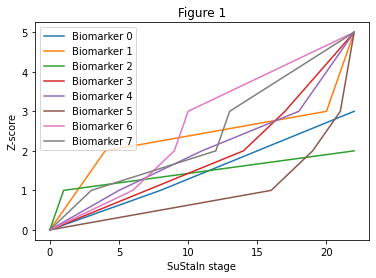

In [2]:
N                       = 8         # number of biomarkers

SuStaInLabels           = []
for i in range(N):
        SuStaInLabels.append( 'Biomarker '+str(i)) # labels of biomarkers for plotting
        
Z_vals                  = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max                   = np.array([5]*N)           # maximum z-score

# To demonstrate how to set different biomarkers to have different z-scores,
# set biomarker 0 to have z-scores of 1 and 2 only and a maximum of 3
# to do this change the corresponding row of Z_vals to read 1 2 0
# and change the corresponding row of Z_max to 3
Z_vals[np.array(0),np.array(2)] = 0
Z_max[np.array(0)] = 3

# and set biomarker 2 to have a z-score of 1 only and a maximum of 2
# to do this change the corresponding row of Z_vals to read 1 0 0 
# and change the corresponding row of Z_max to 2 
Z_vals[np.array(2),np.array([1,2])] = 0
Z_max[np.array(2)] = 2


# generate a random sequence for the linear z-score model
gt_sequence             = generate_random_Zscore_sustain_model(Z_vals,
                                                        1)

# ignore this part, it's only necessary so that the generate_data_sustain function
# can be used in this demo setting
gt_stages = np.array([0])
gt_subtypes = np.array([0])

# this code generates data from z-score sustain 
# - here i've just output the z-score model itself rather than any datapoints
_, _, gt_stage_value = generate_data_Zscore_sustain(gt_subtypes,
                                             gt_stages,
                                             gt_sequence,
                                             Z_vals,
                                             Z_max)

# ignore this part, just calculates some parameters of sustain to output below
stage_zscore            = np.array([y for x in Z_vals.T for y in x])
stage_zscore            = stage_zscore.reshape(1,len(stage_zscore))
IX_select               = stage_zscore>0
stage_zscore            = stage_zscore[IX_select]
stage_zscore            = stage_zscore.reshape(1,len(stage_zscore))
num_zscores             = Z_vals.shape[1]
IX_vals                 = np.array([[x for x in range(N)]] * num_zscores).T
stage_biomarker_index   = np.array([y for x in IX_vals.T for y in x])
stage_biomarker_index   = stage_biomarker_index.reshape(1,len(stage_biomarker_index))
stage_biomarker_index   = stage_biomarker_index[IX_select]
stage_biomarker_index   = stage_biomarker_index.reshape(1,len(stage_biomarker_index))

# print out some of the values and plot a picture of the model
print('Simulated sequence:',(gt_sequence.astype(int).flatten()))
print('At the beginning of the progression (stage 0) the biomarkers have scores of 0')
print('At the stages:',1+np.arange(np.array(stage_zscore).shape[1]))
print('the biomarkers:',stage_biomarker_index[:,gt_sequence.astype(int).flatten()].flatten())
print('reach z-scores of:',stage_zscore[:,gt_sequence.astype(int).flatten()].flatten())
print('At the end of the progression (stage',np.array(stage_zscore).shape[1]+2,') the biomarkers reach scores of:',Z_max)
print('The z-score model assumes individuals belong to some unknown stage of this progression,')
print('with gaussian noise with a standard deviation of 1 for each biomarker')

temp_stages = np.array(range(np.array(stage_zscore).shape[1]+2))
for b in range(N):
    ax = plt.plot(temp_stages, gt_stage_value[b,:,:])

_ = plt.xlabel('SuStaIn stage')    
_ = plt.ylabel('Z-score')    
_ = plt.legend(SuStaInLabels)
_ = plt.title('Figure 1')

## Important note on the linear z-score model

It's natural to think of the progression pattern in Figure 1 as linear in time but this isn't necessarily the case. For example, the time between stages 2 and 3 may be much longer than between stages 8 and 9. This means that the shape of the trajectories may look quite different if indexed by time (although the general order in which the biomarkers progress to different z-scores would remain the same). The linear z-score model simply describes the patient snapshots you would expect to see in a cross-sectional dataset for any particular subtype at a particular stage. The subtypes and stages are considered as hidden variables, which the SuStaIn algorithm identifies directly from the data.

## Generating simulated data

This section of code generates simulated data for the tutorial. Any variables labelled as 'gt' (ground truth) are for generating the simulated data only and would typically not be known beforehand in a real dataset.

You can ignore many of the settings below for now, but in particular
- N_S_gt is the number of subtypes to simulate
- gt_f is the proportion of individuals belonging to each subtype
- gt_sequence is the order in which each biomarker approaches each z-score for each subtype
- gt_subtypes is the subtype of each individual
- gt_stages is the stage of each individual along the progression pattern of their subtype

You can alter these to get a feel for how SuStaIn works on different simulated datasets.

In [3]:
N                       = 8         # number of biomarkers
M                       = 500       # number of observations ( e.g. subjects )
M_control               = 100       # number of these that are control subjects
N_S_gt                  = 4         # number of ground truth subtypes

SuStaInLabels           = []
for i in range(N):
        SuStaInLabels.append( 'Biomarker '+str(i)) # labels of biomarkers for plotting
        
Z_vals                  = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max                   = np.array([5]*N)           # maximum z-score
   
# ground truth proportion of individuals belonging to each subtype    
gt_f                    = [1+0.5*x for x in range(N_S_gt)]
gt_f                    = [x/sum(gt_f) for x in gt_f][::-1]

# ground truth sequence for each subtype
gt_sequence             = generate_random_Zscore_sustain_model(Z_vals,
                                                        N_S_gt)

# simulate subtypes and stages for individuals, including a control population at stage 0
N_k                     = np.sum(Z_vals>0)+1
gt_subtypes             = np.random.choice(range(N_S_gt), M, replace=True, p=gt_f)
gt_stages_control       = np.zeros((M_control,1))
gt_stages               = np.concatenate((gt_stages_control,
                                         np.ceil(np.random.rand(M-M_control,1)*N_k)),
                                        axis=0)

# generate simulated data
data, gt_data_denoised, gt_stage_value = generate_data_Zscore_sustain(gt_subtypes,
                                                               gt_stages,
                                                               gt_sequence,
                                                               Z_vals,
                                                               Z_max)

# ignore this part, just calculates some parameters of sustain to output below
stage_zscore            = np.array([y for x in Z_vals.T for y in x])
stage_zscore            = stage_zscore.reshape(1,len(stage_zscore))
IX_select               = stage_zscore>0
stage_zscore            = stage_zscore[IX_select]
stage_zscore            = stage_zscore.reshape(1,len(stage_zscore))
num_zscores             = Z_vals.shape[1]
IX_vals                 = np.array([[x for x in range(N)]] * num_zscores).T
stage_biomarker_index   = np.array([y for x in IX_vals.T for y in x])
stage_biomarker_index   = stage_biomarker_index.reshape(1,len(stage_biomarker_index))
stage_biomarker_index   = stage_biomarker_index[IX_select]
stage_biomarker_index   = stage_biomarker_index.reshape(1,len(stage_biomarker_index))

for s in range (N_S_gt):
    # print out the parameters
    print('For subtype',s,'(',gt_f[s]*100,'% of individuals)')
    print('Simulated sequence:',(gt_sequence[s,:].astype(int).flatten()))
    print('At the beginning of the progression (stage 0) the biomarkers have scores of 0')
    print('At the stages:',1+np.arange(np.array(stage_zscore).shape[1]))
    print('the biomarkers:',stage_biomarker_index[:,gt_sequence[s,:].astype(int).flatten()].flatten())
    print('reach z-scores of:',stage_zscore[:,gt_sequence[s,:].astype(int).flatten()].flatten())
    print('At the end of the progression (stage',np.array(stage_zscore).shape[1]+2,') the biomarkers reach scores of:',Z_max)
    print('')

For subtype 0 ( 35.714285714285715 % of individuals)
Simulated sequence: [ 2  1  3  5 11  0  9 13 10  8 17 16 19  6  4 14 21 12  7 15 20 18 23 22]
At the beginning of the progression (stage 0) the biomarkers have scores of 0
At the stages: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
the biomarkers: [2 1 3 5 3 0 1 5 2 0 1 0 3 6 4 6 5 4 7 7 4 2 7 6]
reach z-scores of: [1 1 1 1 2 1 2 2 2 2 3 3 3 1 1 2 3 2 1 2 3 3 3 3]
At the end of the progression (stage 26 ) the biomarkers reach scores of: [5 5 5 5 5 5 5 5]

For subtype 1 ( 28.57142857142857 % of individuals)
Simulated sequence: [ 0  4 12  7  6 15 14  3 22  8  5 16  1 11  2 13  9 21 20 19 10 17 23 18]
At the beginning of the progression (stage 0) the biomarkers have scores of 0
At the stages: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
the biomarkers: [0 4 4 7 6 7 6 3 6 0 5 0 1 3 2 5 1 5 4 3 2 1 7 2]
reach z-scores of: [1 1 2 1 1 2 2 1 3 2 1 3 1 2 1 2 2 3 3 3 2 3 3 3]
At the end

## The SuStaIn algorithm

SuStaIn identifies subtypes with distinct progression patterns from cross-sectional data. The algorithm proceeds hierarchically, first fitting a single subtype to the data, then two, then three, etc., up to a maximum number of subtypes chosen by the user. The fitting of the nth subtype model works but splitting each of the previous n-1 clusters into two and then using this as an initialisation to fit the n subtype model. For each of the n subtype models, SuStaIn uses MCMC sampling to estimate the uncertainty in the subtype progression patterns and the proportion of individuals that belong to each subtype. The optimal number of subtypes is selected by using cross-validation to compute the cross-validation information criterion (CVIC).

## Preparing data for SuStaIn

The data for SuStaIn needs to be z-scored relative to a control population such that the mean of the control population is 0 and the standard deviation of the control population is 1. To do this simply subtract the mean of the control population from your data and divide by the standard deviation of the control population. Double check that if you apply this transformation to the control population only that the control population has a mean of 0 and a standard deviation of 1. The data further needs to be transformed to increase in z-score with disease progression. If the biomarkers you are using decrease with disease progression you need to multiply the data for those biomarkers by -1.

I'd suggest the following workflow for getting your data ready to run SuStaIn on.

1. Regress out the effects of covariates. Learn the effects of covariates in a control population and use this model to regress out the effect of covariates for all the subjects. Learning the model in the control population will avoid regressing out disease effects, which you want to keep in your dataset.

2. Calculate the mean and standard deviation of each biomarker in your control dataset, mean_control and std_control.

3. Z-score your data by taking (data-mean_control)/std_control.

4. Identify any biomarkers that decrease with disease progression, these will have mean_data < mean_control. Multiply the data for these biomarkers by -1.

Steps 2-4 are illustrated in the section below but will have little effect on the simulated data because it is generated as z-scores already.

In [4]:
# extract data for control subjects
data_control = data[np.tile(gt_stages,(1,N))==0].reshape(M_control,N)

# compute the mean and standard deviation of the control population
mean_control = np.mean(data_control,axis=0)
std_control = np.std(data_control,axis=0)

# z-score the data
data = (data-mean_control)/std_control
data_control = (data_control-mean_control)/std_control

# multiply data for decreasing biomarkers by -1
IS_decreasing = np.mean(data,axis=0)<np.mean(data_control,axis=0)
data[np.tile(IS_decreasing,(M,1))] = -1*data[np.tile(IS_decreasing,(M,1))]
data_control[np.tile(IS_decreasing,(M_control,1))] = -1*data_control[np.tile(IS_decreasing,(M_control,1))]

# Check that the mean of the control population is 0
print('Mean of controls is ',np.mean(data_control,axis=0))
# Check that the standard deviation of the control population is 1
print('Standard deviation of controls is ',np.std(data_control,axis=0))
# Check that the mean of the whole dataset is positive
print('Mean of whole dataset is ',np.mean(data,axis=0))
# Check that the standard deviation of the whole dataset is greater than 1
print('Standard deviation of whole dataset is ',np.std(data,axis=0))

Mean of controls is  [ 1.33226763e-17  3.55271368e-17  5.55111512e-19 -8.43769499e-17
 -4.66293670e-17  9.99200722e-18 -1.55431223e-17  4.16333634e-17]
Standard deviation of controls is  [1. 1. 1. 1. 1. 1. 1. 1.]
Mean of whole dataset is  [2.28861742 2.25994534 1.38195663 2.22569733 1.91812071 1.38720092
 1.73821978 1.68502206]
Standard deviation of whole dataset is  [2.07976322 2.2021612  1.69421494 2.0081455  1.90085241 1.75828055
 1.8268627  1.99597538]


## Choosing the settings
The SuStaIn algorithm requires the following inputs.

### data
The data you want to run SuStaIn on, of size M subjects by N biomarkers. This needs to be z-scored in the way described in the previous section.

### Z_vals
This is the set of z-scores you want to include for each biomarker. The more z-scores you use the longer the SuStaIn algorithm will take to run. Z_vals has size N biomarkers by Z z-scores. If you have more z-scores for some biomarkers than others you can simply leave zeros at the end of biomarker rows with fewer z-scores.

### Z_max
The maximum z-score reached at the end of the progression, with size N biomarkers by 1. I'd suggest choosing a value around the 95th percentile of your data but you can experiment with different values. I typically choose an integer for interpretability but you don't have to.

### SuStaInLabels
The names of the biomarkers you are using, for plotting purposes.

### N_startpoints
The number of startpoints to use when fitting the subtypes hierarchichally. I'd suggest using 25.

### N_S_max
The maximum number of subtypes to fit. I'd suggest starting with a lower number - maybe three - and then increasing that if you're getting a significantly better fit with the maximum number of subtypes. You can judge this roughly from the MCMC plot. To properly evaluate the optimal number of subtypes you need to run cross-validation.

### N_iterations_MCMC
The number of iterations for the MCMC sampling of the uncertainty in the progression pattern. I'd recommend using 1x10^5 or 1x10^6.

### output_folder
Choose an output folder for the results.

### dataset_name
Name the results files outputted by SuStaIn.

### use_parellel_startpoints
Boolean for whether or not to parallelize the startpoints.

### Additional note
There are approximate and exact versions of the computation of the data likelihood for the linear z-score model. Currently the python version only supports the approximate version. If you want to use the exact version please see the Matlab version at https://github.com/ucl-pond/SuStaInMatlab.

In [5]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though
N_startpoints = 10
N_S_max = N_S_gt+1
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), 'sim')
dataset_name = 'sim'
sustain_input = pySuStaIn.ZscoreSustain(data,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

In [13]:
N_S_max

5

## Deleting previous SuStaIn results if necessary

This code snippet deletes any previous SuStaIn results. By default the SuStaIn code checks for previous results to avoid running the algorithm again unnecessarily so you'll need to run this section each time you generate a new simulated dataset that you want to fit the SuStaIn model. If you don't want to overwrite your previous results you can choose a new dataset_name and/or output_folder.

In [6]:
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
# output_folder = os.path.join(os.getcwd(), 'sim2')    
# dataset_name = 'sim2' 
# sustain_input = ZscoreSustain(data,
#                               Z_vals,
#                               Z_max,
#                               SuStaInLabels,
#                               N_startpoints,
#                               N_S_max, 
#                               N_iterations_MCMC, 
#                               output_folder, 
#                               dataset_name, 
#                               False)

## Create folder for results if it doesn't exist already

In [7]:
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

## Running the SuStaIn algorithm

We're finally ready to run the SuStaIn algorithm! The main outputs are samples_sequence and samples_f. samples_sequence gives MCMC samples of the ordering of the biomarker z-scores for each n subtype model. samples_f gives MCMC samples of the proportion of individuals that belong to each subtype for each n subtype model. These can be found in the outputted files.

In [8]:
# runs the sustain algorithm with the inputs set in sustain_input above
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /Users/seymour/Downloads/pySuStaIn-1-master_1/notebooks/sim/pickle_files/sim_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -7473.679019023702


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/seymour/Downloads/pySuStaIn-1-master_1/notebooks/sim/pickle_files/sim_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7108.34262497]
Overall ML likelihood is [-7108.34262497]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/seymour/Downloads/pySuStaIn-1-master_1/notebooks/sim/pickle_files/sim_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7035.7626382]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7018.2849747]
Overall ML likelihood is [-7018.2849747]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/seymour/Downloads/pySuStaIn-1-master_1/notebooks/sim/pickle_files/sim_subtype3.pickle. Running SuStaIn model for 3 subtype.
Splitting cluster 1 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6978.00323241]
Splitting cluster 2 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-7006.92546494]
Splitting cluster 3 of 3
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6979.60113013]
Overall ML likelihood is [-6978.00323241]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Failed to find pickle file: /Users/seymour/Downloads/pySuStaIn-1-master_1/notebooks/sim/pickle_files/sim_subtype4.pickle. Running SuStaIn model for 4 subtype.
Splitting cluster 1 of 4
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6966.32819289]
Splitting cluster 2 of 4
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6972.19479309]
Splitting cluster 3 of 4
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6966.21926644]
Splitting cluster 4 of 4
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6963.84890007]
Overall ML likelihood is [-6963.84890007]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
#BIC difference >10 indicates very strong evidence of the models being different, 6-10 indicates strong evidence,
#2-6 indicates positive evidence and 0-2 indicates weak evidence.
#Ref: https://link.springer.com/article/10.3758/s13428-018-1188-3#:~:text=The%20difference%20between%20the%20BICs,model%20(Raftery%2C%201995).

def BIC(logML, n,k):
    res = k * np.log(n) -2*logML
    return(res)


split1_BIC=BIC(-6966.32,data.shape[0],1)
split2_BIC=BIC(-6972.19,data.shape[0],2)
split3_BIC=BIC(-6966.21,data.shape[0],3)
split4_BIC=BIC(-6963.84,data.shape[0],4)
print(round(split1_BIC,3))
print(round(split2_BIC,3))
print(round(split3_BIC,3))
print(round(split4_BIC,3))

13938.855
13956.809
13951.064
13952.538


In [19]:
#Here we see strong evidence upto the 3rd split (4 subtypes) and weak evidence at the 4th split (5 subtypes)